# Preprocessing Pipeline 

This notebook explains the preprocessing Pipeline.

Each stage of the pipeline is analyzed with **before/after** visualizations to illustrate the impact of each transformation on the data.

## Pipeline Overview

The preprocessing workflow consists of the following stages:

1. **Data Loading & Initial State** - Raw data inspection and quality assessment
2. **Missing Values Imputation** 
3. **Outlier Removal** - Domain-based and statistical outlier detection
4. **Categorical Encoding** - Converting categorical variables to numerical representations
5. **Feature Engineering** - Deriving new features from existing variables
6. **Feature Scaling** - Standardizing numerical features
7. **Dimensionality Reduction (PCA)** - Reducing feature space while preserving variance

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('default')
sns.set_palette('viridis')

In [5]:
import sys
sys.path.insert(0, '../../src')

from features.outlier_removal import MissingValueTransformer, OutlierRemovalTransformer
from features.encoding import FeatureEncoder
from features.feature_engineering import FeatureEngineer
from features.scaling import FeatureScaler
from features.dimensionality_reduction import FeatureReducer

---
# Data Loading & Initial State

We begin by loading the raw (filtered) dataset and inspecting its structure. This establishes the **baseline state** before any preprocessing transformations are applied.

In [6]:
df_raw = pd.read_csv('../../data/processed/openfoodfacts_filtered.csv')
print("Dataset shape:", "{:,}".format(df_raw.shape[0]), "rows x", df_raw.shape[1], "columns")

Dataset shape: 250,000 rows x 22 columns


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   nutriscore_grade                      250000 non-null  object 
 1   code                                  250000 non-null  object 
 2   product_name                          245761 non-null  object 
 3   brands                                197024 non-null  object 
 4   categories                            249837 non-null  object 
 5   countries                             249365 non-null  object 
 6   energy_100g                           245665 non-null  float64
 7   energy-kcal_100g                      239065 non-null  float64
 8   fat_100g                              245656 non-null  float64
 9   saturated-fat_100g                    239766 non-null  float64
 10  carbohydrates_100g                    245330 non-null  float64
 11  

In [8]:
display(df_raw.head())

,nutriscore_grade,code,product_name,brands,categories,countries,energy_100g,energy-kcal_100g,fat_100g,saturated-fat_100g,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,additives_n,pnns_groups_1,pnns_groups_2,main_category
0,c,3273227035408,Bifidus Sabor Frutos Rojos,Vrai,"Dairies, Fermented foods, Fermented milk produ...",Spain,293.00,70.00,1.60,1.10,...,NaN,3.80,0.10,0.04,NaN,NaN,0.00,Milk and dairy products,Milk and yogurt,en:flavoured-yogurts
1,a,2600013025656,Aiguillettes de poulet,Auchan,"Viandes, Volailles, Poulets, Aiguillettes de p...",en:france,460.00,110.00,1.50,0.50,...,NaN,24.00,0.10,0.04,NaN,NaN,NaN,Fish Meat Eggs,Meat,fr:aiguillettes-de-poulet
2,d,3760112651626,Duo gourmand de chèvre,Etoile du Vercors,"Produits laitiers,Produits fermentés,Produits ...",France,1264.00,302.00,25.00,17.00,...,NaN,18.00,1.75,0.70,NaN,NaN,NaN,Milk and dairy products,Cheese,en:goat-cheeses
3,b,163521,M&S concentrated beef stock,Marks & Spencer,"Beef-stock, Concentrated beef stock",en:United Kingdom,85.00,20.00,1.00,0.50,...,0.50,1.70,0.50,0.20,NaN,NaN,0.00,unknown,unknown,en:concentrated-beef-stock
4,c,3014541007876,Carb balance tortilla,Mission,"plant-based-foods-and-beverages, plant-based-f...",United States,584.00,140.00,8.14,3.49,...,41.90,11.60,1.92,0.77,NaN,NaN,8.00,Cereals and potatoes,Bread,en:wheat-flatbreads


## Numerical Feature Statistics

Initial descriptive statistics reveal the **scale heterogeneity** across features and potential **data quality issues** (e.g., implausible values).

In [9]:
numerical_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
display(df_raw[numerical_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
energy_100g,245665.00,1239.69,5724.98,0.00,444.00,1076.00,1695.00,2305554.00
energy-kcal_100g,239065.00,316.95,8175.57,0.00,106.00,259.00,406.00,3701123.00
fat_100g,245656.00,18.21,1369.15,0.00,1.00,7.80,22.30,678454.00
saturated-fat_100g,239766.00,5.69,18.28,0.00,0.20,2.01,7.77,4878.00
carbohydrates_100g,245330.00,29.79,177.89,0.00,3.50,15.00,52.01,84878.00
sugars_100g,243641.00,13.59,28.07,0.00,0.70,3.57,16.95,4878.00
fiber_100g,139312.00,3.21,15.24,0.00,0.00,1.60,3.70,4848.00
proteins_100g,245653.00,8.97,19.50,0.00,1.60,6.15,12.50,4848.00
salt_100g,245785.00,1.73,38.94,0.00,0.06,0.50,1.30,10740.00
sodium_100g,245785.00,0.69,15.58,0.00,0.02,0.20,0.52,4296.00


---
# Missing Value Analysis & Imputation

Missing data is a critical preprocessing concern. The `MissingValueTransformer` employs a **threshold-based strategy**:

- Features with >95% missing values are **dropped** (insufficient signal)
- Remaining missing values are imputed using **median** (robust to outliers) 

Calculate missing percentages

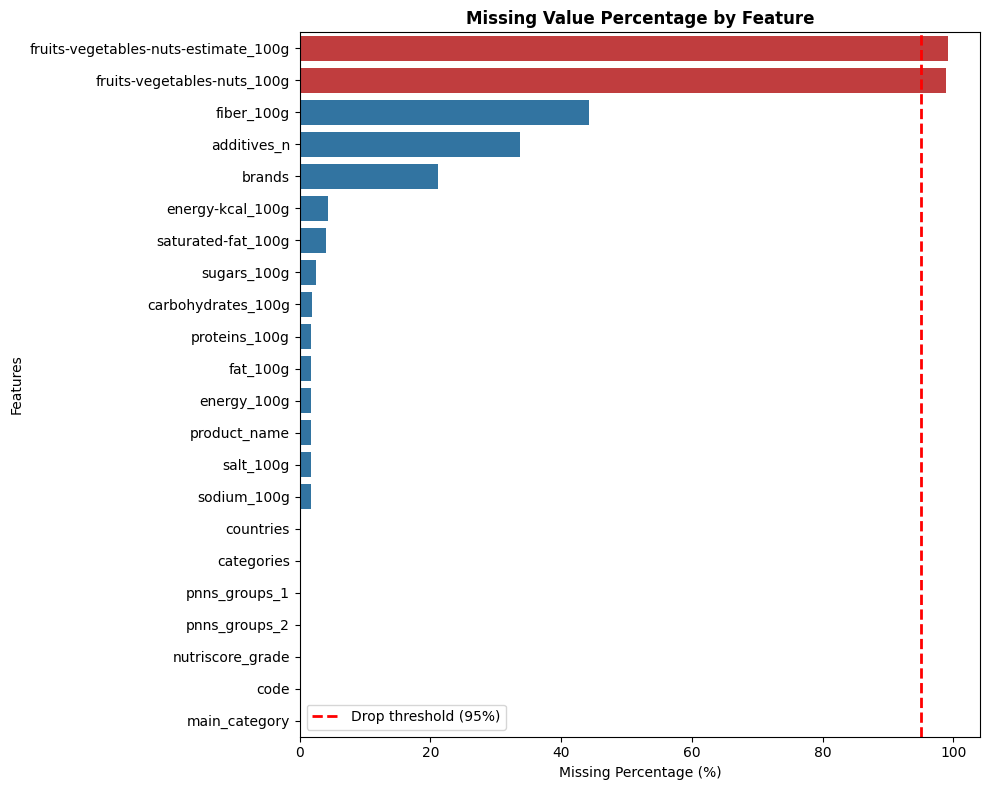

Dropped features (>95 percent missing):
  - fruits-vegetables-nuts-estimate_100g
  - fruits-vegetables-nuts_100g


In [10]:
missing_pct = (df_raw.isnull().sum() / len(df_raw)) * 100
missing_pct = missing_pct.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#d62728' if pct > 95 else '#1f77b4' for pct in missing_pct.values]

sns.barplot(
    y=missing_pct.index,
    x=missing_pct.values,
    palette=colors,
    hue=missing_pct.index,
    orient='h'
)

plt.axvline(x=95, color='red', linestyle='--', linewidth=2, label='Drop threshold (95%)')
plt.title('Missing Value Percentage by Feature', fontsize=12, fontweight='bold')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.show()

high_missing = missing_pct[missing_pct > 95]
print("Dropped features (>{} percent missing):".format(95))
for feat in high_missing.index:
    print("  -", feat)

### Apply missing value transformation

In [11]:
missing_handler = MissingValueTransformer(threshold_drop_feature=0.95, target_col='nutriscore_grade')
df_no_missing = missing_handler.fit_transform(df_raw)

print("\nShape after missing value handling:", df_no_missing.shape)
print("Dropped features:", missing_handler.dropped_features_)

                     Operation: Missing value imputation and feature filtering
                              - Dropped: 'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts_100g'
                              - Imputed numerical: 'energy_100g'=1076.0, 'energy-kcal_100g'=259.0, (+9 more)
                              - Imputed categorical: 'product_name', 'brands' (+2 more) -> 'unknown'

Shape after missing value handling: (250000, 20)
Dropped features: []


---
# Outlier Detection and Removal

Outlier handling is essential for robust model training. The `OutlierRemovalTransformer` employs a **two-stage approach**:

### Domain-Based Validation
Nutritional values have **physical constraints** (e.g., percentages cannot exceed 100g per 100g):

| Feature | Valid Range |  |
|---------|-------------|------------|
| `fat_100g` | [0, 100] | Maximum 100g fat per 100g product |
| `sugars_100g` | [0, 100] | Maximum 100g sugar per 100g product |
| `fiber_100g` | [0, 100] | Maximum 100g fiber per 100g product |
| `energy_100g` | [0, 5000] | kJ upper limit based on pure fat |

### Statistical Outlier Detection 
Using **IQR method** with 3x threshold for extreme values.


# Before outlier removal

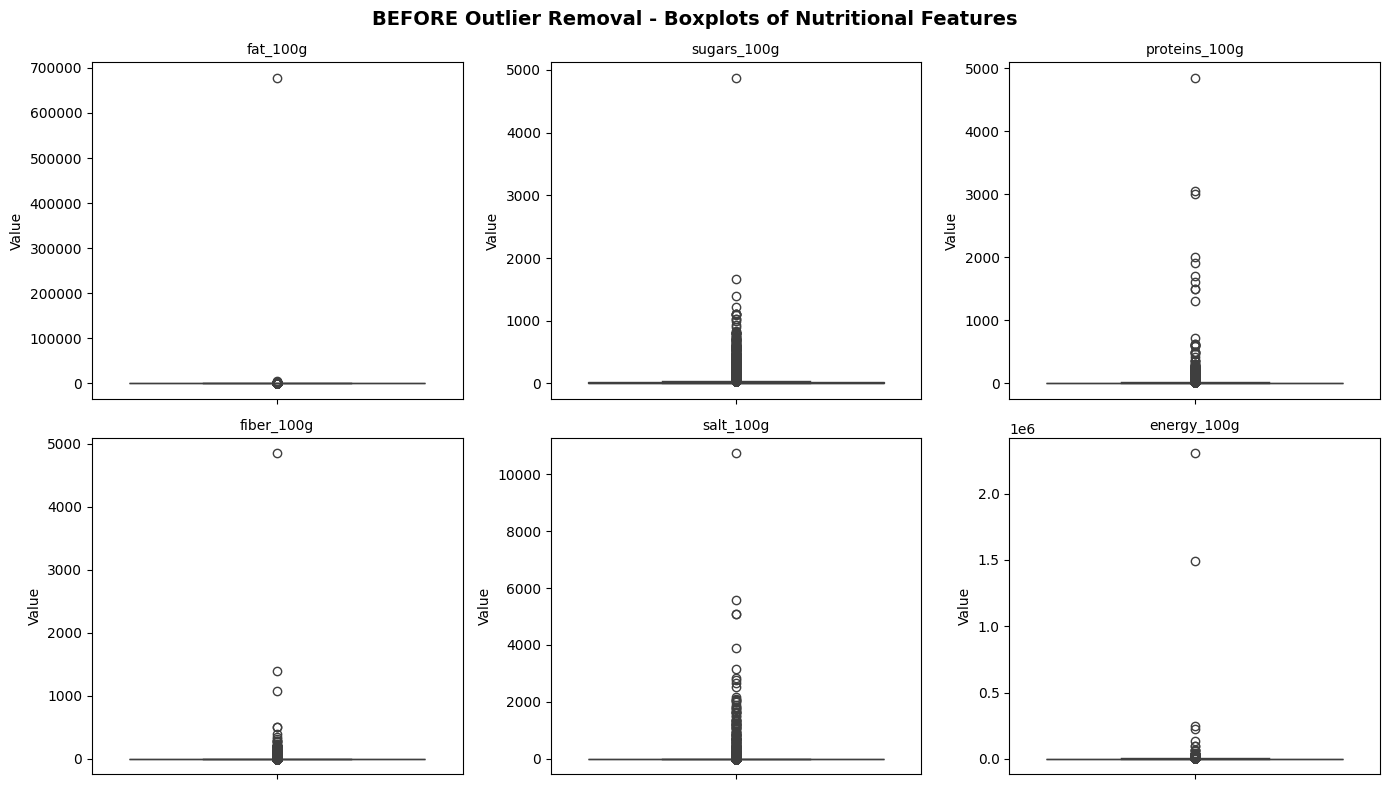

In [12]:
outlier_features = ['fat_100g', 'sugars_100g', 'proteins_100g', 'fiber_100g', 'salt_100g', 'energy_100g']
outlier_features = [f for f in outlier_features if f in df_no_missing.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('BEFORE Outlier Removal - Boxplots of Nutritional Features', fontsize=14, fontweight='bold')

for idx, feat in enumerate(outlier_features):
    ax = axes[idx // 3, idx % 3]
    sns.boxplot(data=df_no_missing, y=feat, ax=ax, color='#1f77b4')
    ax.set_title(f'{feat}', fontsize=10)
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

### Apply outlier removal

In [13]:
outlier_handler = OutlierRemovalTransformer(
    target_col='nutriscore_grade',
    remove_statistical_outliers=True
)

df_clean = outlier_handler.fit_transform(df_no_missing)

print("\nRows before:", len(df_no_missing))
print("Rows after: ", len(df_clean))
print("Removed:    ", outlier_handler.rows_removed_, "(", outlier_handler.outlier_report_['removal_percentage'], "%)")


                     Operation: Outlier detection and removal
                              - Method: Domain-based range validation
                              - Validated: 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'energy_100g', 'energy-kcal_100g'
                              - Total removed: 56,352 rows (22.54%)
                              - Top outliers: 'carbohydrates_100g' (2128), 'fat_100g' (1081), 'energy-kcal_100g' (177)
                              - Statistical method: IQR (3x threshold)

Rows before: 250000
Rows after:  193648
Removed:     56352 ( 22.5408 %)


### After outlier removal 

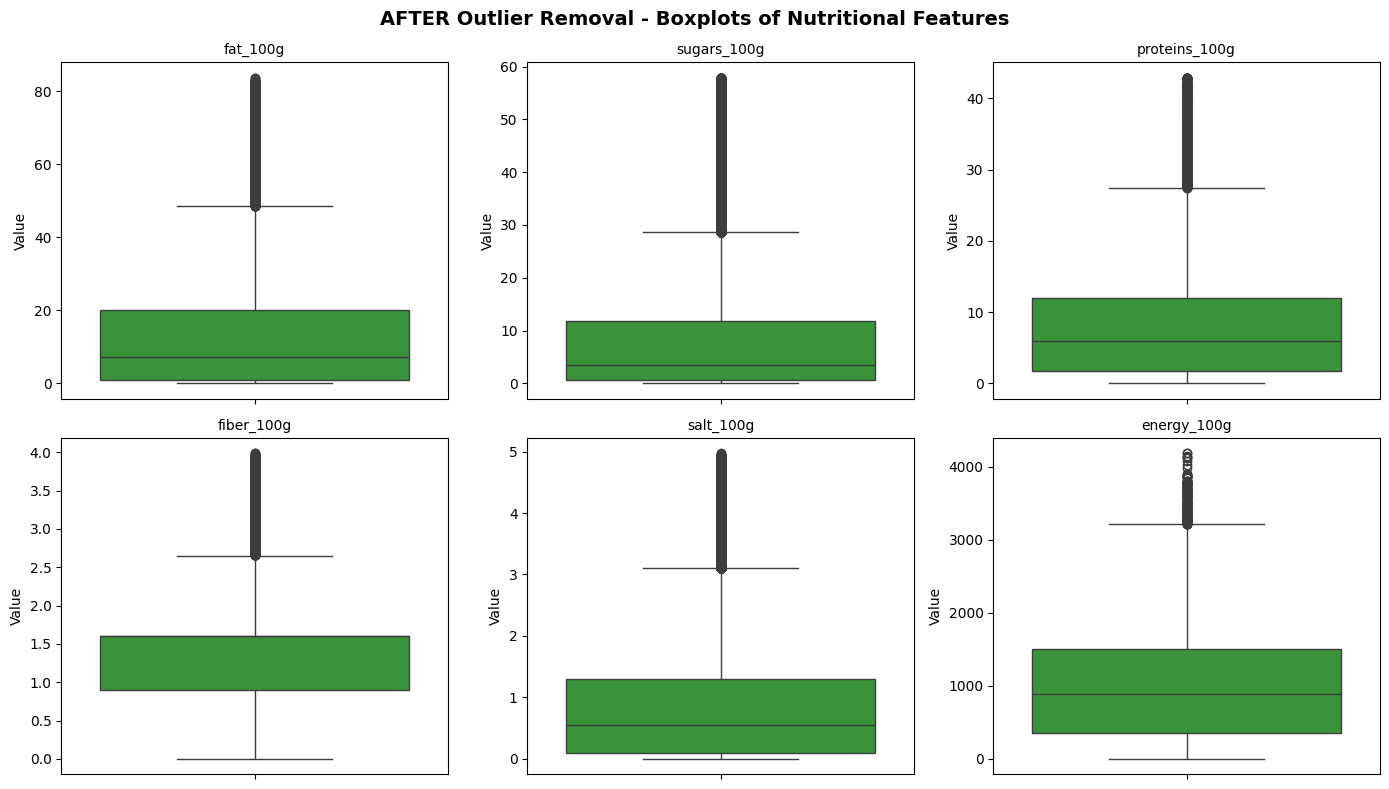

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('AFTER Outlier Removal - Boxplots of Nutritional Features', fontsize=14, fontweight='bold')

for idx, feat in enumerate(outlier_features):
    if feat not in df_clean.columns:
        continue
    ax = axes[idx // 3, idx % 3]
    sns.boxplot(data=df_clean, y=feat, ax=ax, color='#2ca02c')
    ax.set_title(f'{feat}', fontsize=10)
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

---
# Categorical Encoding

Machine learning models require numerical inputs. The `FeatureEncoder` applies **context-appropriate encoding strategies**:

| Feature | Encoding Method | Rationale |
|---------|----------------|------------|
| `countries` | **Multi-Label Binarization** | Products can belong to multiple countries |
| `pnns_groups_1` | **One-Hot Encoding** | Nominal categorical with moderate cardinality |
| `pnns_groups_2` | **Target Encoding** | High cardinality - encodes mean target value |

### Technical Details:
- **Multi-Label Binarizer**: Creates binary columns for top-N countries
- **One-Hot Encoding**: Sparse representation 
- **Target Encoding**: Smoothed mean encoding reduces overfitting risk

### Before encoding - categorical features

In [15]:
categorical_features = ['countries', 'pnns_groups_1', 'pnns_groups_2']
categorical_features = [feature for feature in categorical_features if feature in df_clean.columns]

for feat in categorical_features:
    n_unique = df_clean[feat].nunique()
    print(f"{feat}:")
    print("  Unique values:", n_unique)
    if n_unique <= 10:
        print("  Values:", df_clean[feat].unique()[:10])
    else:
        print("  Sample values:", df_clean[feat].unique()[:5])
    print()

countries:
  Unique values: 4703
  Sample values: ['Spain' 'en:france' 'France' 'en:United Kingdom' 'United States']

pnns_groups_1:
  Unique values: 11
  Sample values: ['Milk and dairy products' 'Fish Meat Eggs' 'unknown' 'Salty snacks'
 'Sugary snacks']

pnns_groups_2:
  Unique values: 40
  Sample values: ['Milk and yogurt' 'Meat' 'Cheese' 'unknown' 'Processed meat']



Visualize `pnns_groups_1` distribution before encoding

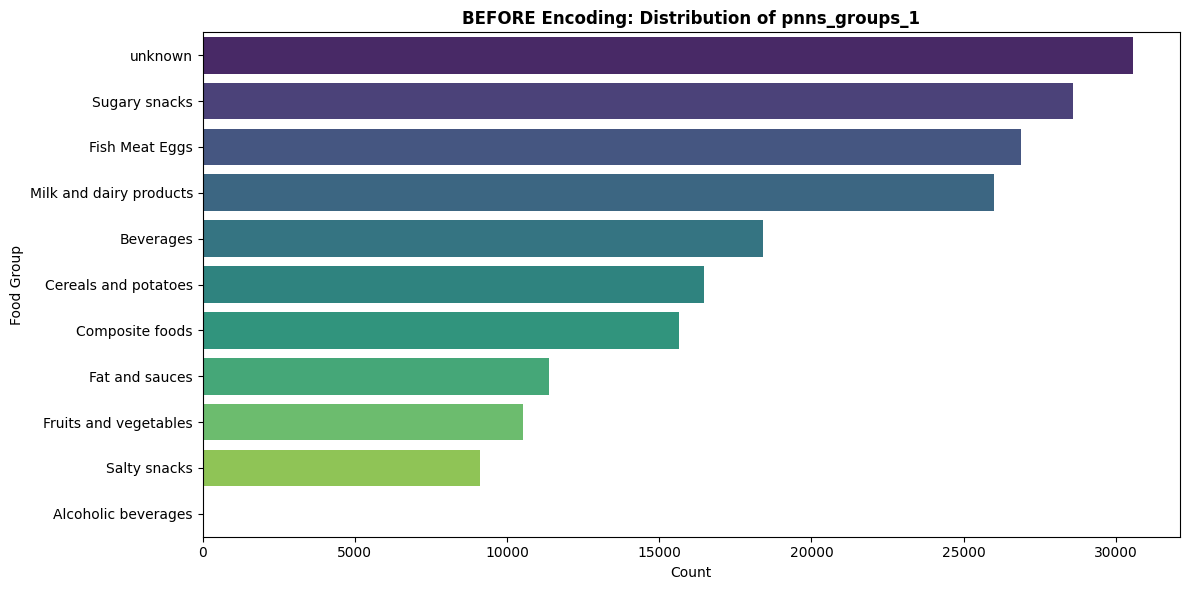

In [16]:

if 'pnns_groups_1' in df_clean.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    group_counts = df_clean['pnns_groups_1'].value_counts()
    
    sns.barplot(
        x=group_counts.values,
        y=group_counts.index,
        palette='viridis',
        hue=group_counts.index,
        orient='h'
    )
    
    plt.title('BEFORE Encoding: Distribution of pnns_groups_1', fontsize=12, fontweight='bold')
    plt.xlabel('Count')
    plt.ylabel('Food Group')
    plt.tight_layout()
    plt.show()

Apply encoding

In [17]:
encoder = FeatureEncoder(top_n_countries=15, target_col='nutriscore_grade')
df_encoded = encoder.fit_transform(df_clean)

print(f"\nShape before encoding: {df_clean.shape}")
print(f"Shape after encoding:  {df_encoded.shape}")
print(f"New columns created:   {df_encoded.shape[1] - df_clean.shape[1] + len(categorical_features)}")

                     Operation: Categorical feature encoding
                              - Encoded features: 'countries', 'pnns_groups_1', 'pnns_groups_2'
                              - Methods: MultiLabel (countries), OneHot (groups), Target
                              - Transformation: 3 features -> 27 numeric columns

Shape before encoding: (193648, 20)
Shape after encoding:  (193648, 44)
New columns created:   27


### After encoding

In [18]:
country_cols = [c for c in df_encoded.columns if c.startswith('countries_')]
print("Countries (MLB):", len(country_cols), "features")
print("Examples:", country_cols[:5])

pnns1_cols = [c for c in df_encoded.columns if c.startswith('pnns_groups_1_')]
print("PNNS Groups 1 (OHE):", len(pnns1_cols), "features")
print("Examples:", pnns1_cols[:5])

if 'pnns_groups_2' in df_encoded.columns:
    col = df_encoded['pnns_groups_2']
    print("PNNS Groups 2 (TE): 1 feature | Range: [", round(col.min(), 3), ",", round(col.max(), 3), "]")

Countries (MLB): 15 features
Examples: ['countries_France', 'countries_United States', 'countries_Germany', 'countries_Spain', 'countries_Italy']
PNNS Groups 1 (OHE): 11 features
Examples: ['pnns_groups_1_Alcoholic beverages', 'pnns_groups_1_Beverages', 'pnns_groups_1_Cereals and potatoes', 'pnns_groups_1_Composite foods', 'pnns_groups_1_Fat and sauces']
PNNS Groups 2 (TE): 1 feature | Range: [ 0.0 , 0.815 ]


### Visualize encoded country distribution 

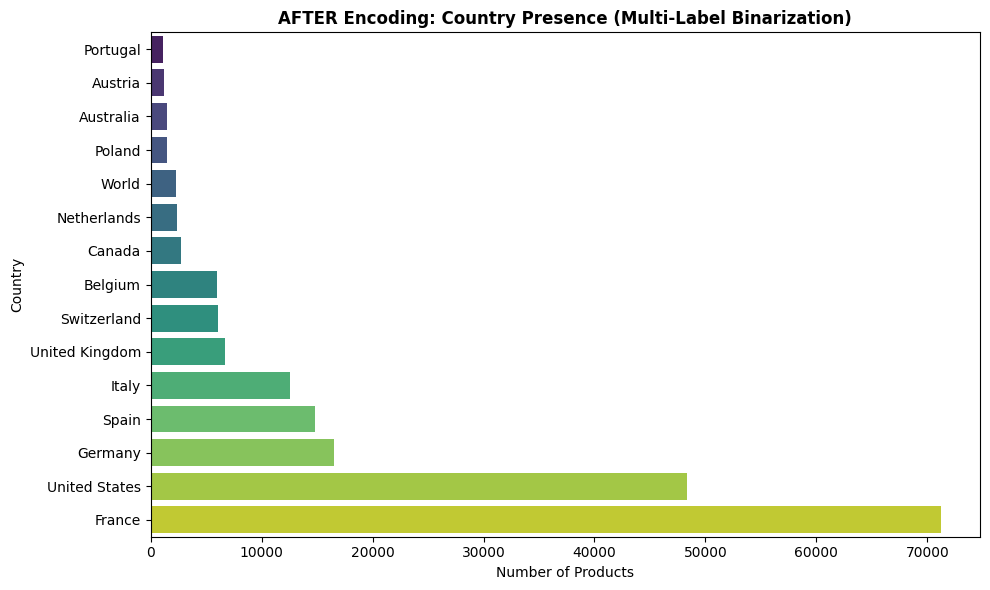

In [19]:
if country_cols:
    country_sums = df_encoded[country_cols].sum().sort_values(ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    country_names = []
    for c in country_sums.index:
        country_names.append(c.replace('countries_', ''))

    sns.barplot(
        x=country_sums.values,
        y=country_names,
        palette='viridis',
        hue=country_names,
        orient='h'
    )
    
    plt.title('AFTER Encoding: Country Presence (Multi-Label Binarization)', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Products')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()

---
# Feature Engineering

The `FeatureEngineer` creates **derived features** that capture nutritional relationships:

### Nutrient Ratios
- `fat_to_protein_ratio`: Indicates macronutrient balance
- `sugar_to_carb_ratio`: Measures proportion of simple vs complex carbs
- `saturated_to_total_fat_ratio`: Fat quality indicator

### Caloric Contributions
Derived using standard conversion factors:
- Fat: 9 kcal/g
- Carbohydrates: 4 kcal/g
- Protein: 4 kcal/g

### Boolean Threshold Flags
Binary indicators based on nutritional guidelines:
- `high_fat`: fat_100g > 20g
- `high_sugar`: sugars_100g > 15g
- `high_salt`: salt_100g > 1.5g

In [20]:
print(f"Number of features: {df_encoded.shape[1]}")

Number of features: 44


In [21]:
feature_engineer = FeatureEngineer(
    add_ratios=True,
    add_energy_density=True,
    add_caloric_contributions=True,
    add_boolean_flags=True
)

df_engineered = feature_engineer.fit_transform(df_encoded)

print(f"\nShape after feature engineering: {df_engineered.shape}")

                     Operation: Feature engineering
                              - Created 10 new features
                              - Examples: 'fat_to_protein_ratio', 'sugar_to_carb_ratio', 'saturated_to_total_fat_ratio', 'energy_density' (+6 more)
                              - Categories: nutrient ratios, energy density, caloric contributions, threshold flags

Shape after feature engineering: (193648, 54)


In [22]:
engineered_features = [col for col in df_engineered.columns if col not in df_encoded.columns]

for feat in engineered_features:
    print(f"  - {feat}")
    
print(f"\nTotal new features: {len(engineered_features)}")

  - fat_to_protein_ratio
  - sugar_to_carb_ratio
  - saturated_to_total_fat_ratio
  - energy_density
  - calories_from_fat
  - calories_from_carbs
  - calories_from_protein
  - high_fat
  - high_sugar
  - high_salt

Total new features: 10


### Visualize boolean flag features

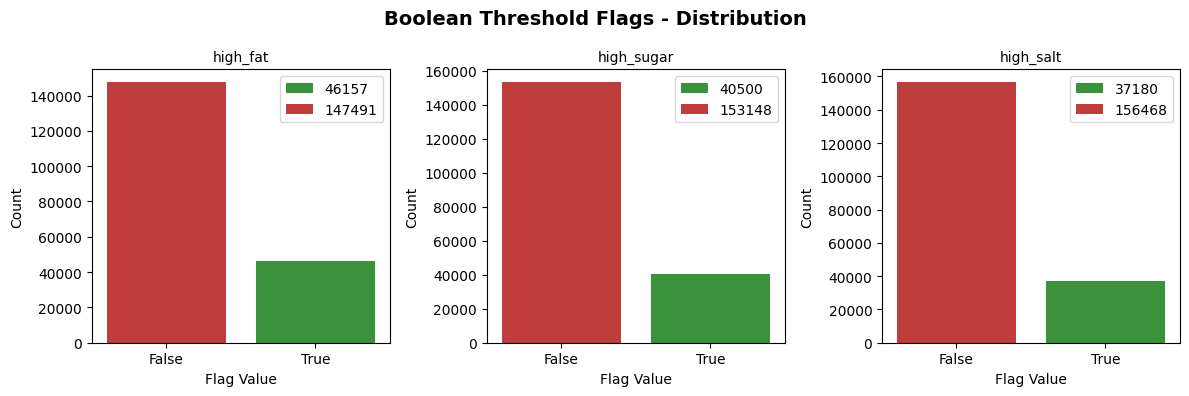

In [23]:
flag_features = ['high_fat', 'high_sugar', 'high_salt']
flag_features = [f for f in flag_features if f in df_engineered.columns]

if flag_features:
    fig, axes = plt.subplots(1, len(flag_features), figsize=(12, 4))
    fig.suptitle('Boolean Threshold Flags - Distribution', fontsize=14, fontweight='bold')
    
    for idx, feat in enumerate(flag_features):
        ax = axes[idx] if len(flag_features) > 1 else axes
        counts = df_engineered[feat].value_counts().sort_index()
        
        sns.barplot(
            x=['False', 'True'],
            y=[counts.get(0, 0), counts.get(1, 0)],
            ax=ax,
            palette=['#2ca02c', '#d62728'],
            hue = [counts.get(0, 0), counts.get(1, 0)]
        )
        
        ax.set_title(f'{feat}', fontsize=10)
        ax.set_xlabel('Flag Value')
        ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

---
# Feature Scaling

Scaling ensures all features contribute equally to model training. The `FeatureScaler` supports multiple strategies:

| Method | Best For |
|--------|----------|
| **StandardScaler** | Normally distributed features |
| **MinMaxScaler** | Bounded features, skewed distributions |
| **RobustScaler** | Outlier-sensitive features |

### Auto Selection
When `method='auto'`, the scaler is chosen based on **skewness**:
- |skewness| > threshold → MinMaxScaler
- Otherwise → StandardScaler

### Log Transformation
Highly skewed ratio features undergo `log1p` transformation before StandardScaler to approximate normality.

### Preferred method
`Standard` is the method shown to give the best results.

In [24]:
# Apply scaling
scaler = FeatureScaler(method='standard',skew_threshold=1.0)
df_scaled = scaler.fit_transform(df_engineered)

print(f"\nScaled {len(scaler.scalers_)} features")

                     Operation: Feature scaling
                              - Scaled 48 numerical features
                              - Methods: 48 Standard

Scaled 48 features


In [25]:
scale_features_available = [
    'energy_100g',
    'fat_100g',
    'fat_to_protein_ratio',
    'sugar_to_carb_ratio',
    'sugars_100g',
    'proteins_100g',
    'salt_100g',
    'additives_n'
]

# Scaling Before/After comparison

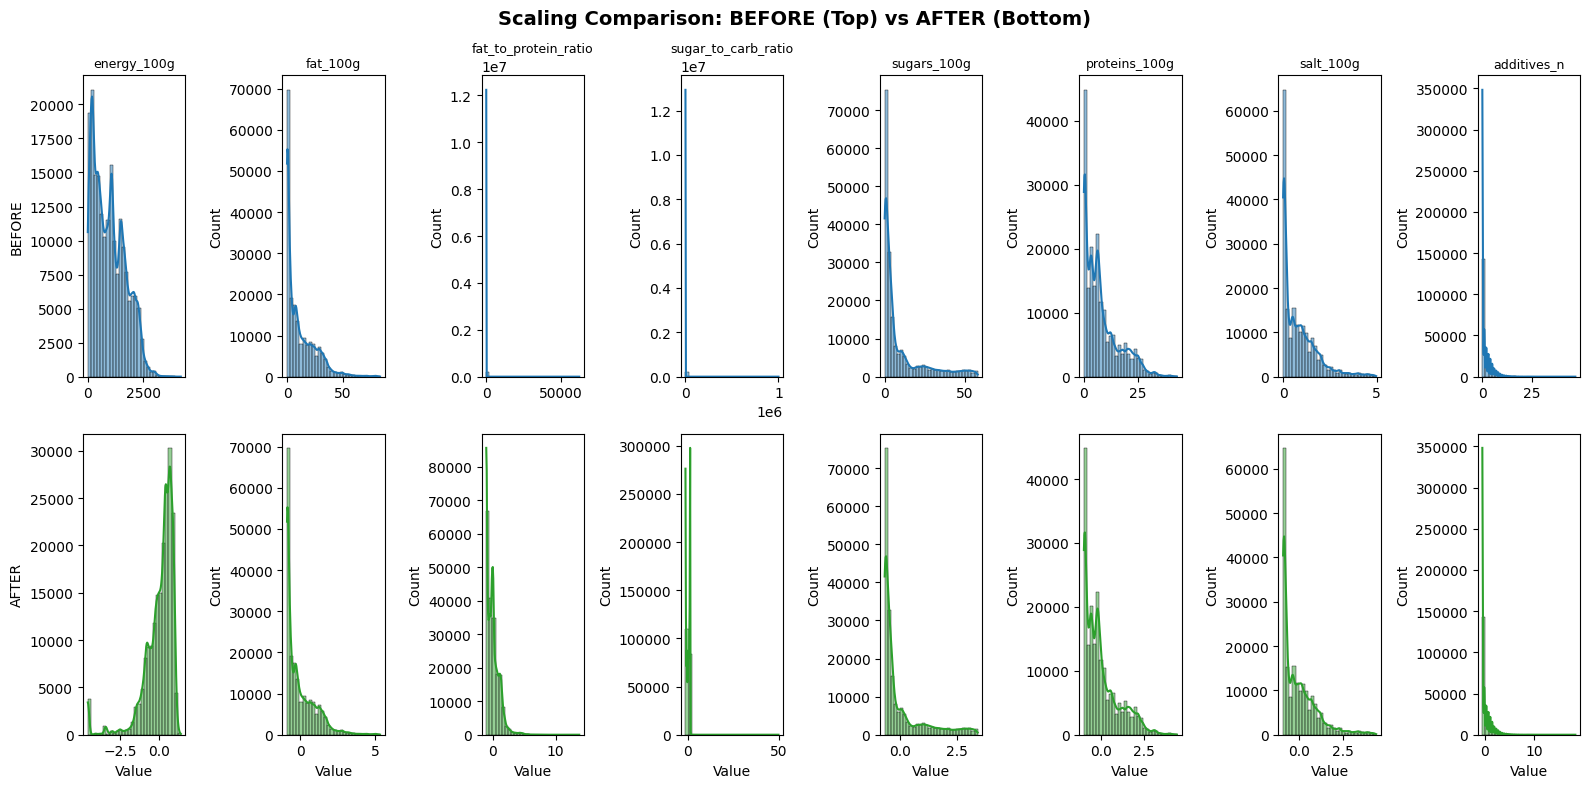

In [26]:
fig, axes = plt.subplots(2, len(scale_features_available), figsize=(16, 8))
fig.suptitle('Scaling Comparison: BEFORE (Top) vs AFTER (Bottom)', fontsize=14, fontweight='bold')

for idx, feat in enumerate(scale_features_available):
    
    ax_before = axes[0, idx]
    sns.histplot(data=df_engineered[feat].dropna(), ax=ax_before, kde=True, color='#1f77b4', bins=30)
    ax_before.set_title(f'{feat}', fontsize=9)
    ax_before.set_xlabel('')
    if idx == 0:
        ax_before.set_ylabel('BEFORE')
    
    ax_after = axes[1, idx]
    sns.histplot(data=df_scaled[feat].dropna(), ax=ax_after, kde=True, color='#2ca02c', bins=30)
    ax_after.set_xlabel('Value')
    if idx == 0:
        ax_after.set_ylabel('AFTER')

plt.tight_layout()
plt.show()

---
#  Dimensionality Reduction (PCA)

**Principal Component Analysis (PCA)** reduces the feature space while preserving maximum variance:

### Configuration
- `variance_threshold=0.95`: Retain components explaining 95% of variance
- Components are orthogonal (uncorrelated)
- Metadata columns are preserved separately

**Before PCA** - feature count

In [27]:
metadata_cols = [
    'nutriscore_grade',
    'split_group',
    'product_name',
    'brands',
    'code'
]

numerical_cols_pca = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
pca_features = []
for c in numerical_cols_pca:
    if c not in metadata_cols:
        pca_features.append(c)

print("Number of numerical features for PCA:", len(pca_features))

Number of numerical features for PCA: 48


Apply **PCA**

In [28]:
pca_reducer = FeatureReducer(variance_threshold=0.95)
df_pca = pca_reducer.fit_transform(df_scaled)


PCA fitted: 32 components selected
Explained variance: 0.9580 (95.80%)
Feature reduction: 48 -> 32 components


## Cumulative and Individual Variance

Now we visualize the **scree plot** for individual variance and the cumulative explained variance graph

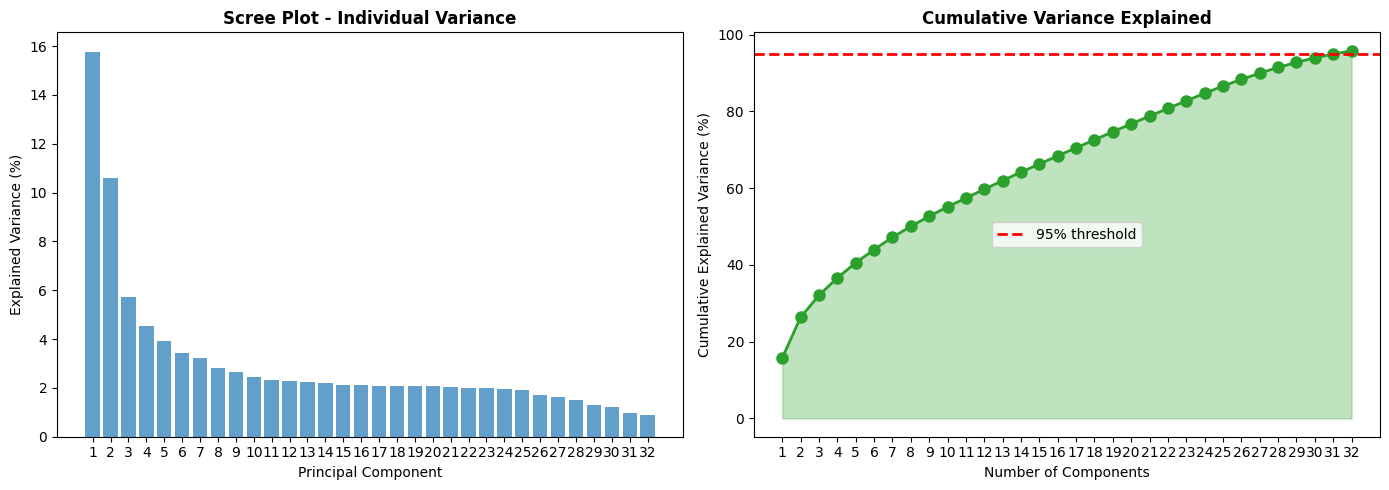

Components selected: 32
Total variance explained: 95.80%


In [29]:
explained_var = pca_reducer.get_explained_variance_ratio()
cumulative_var = pca_reducer.get_cumulative_variance()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
component_indices = range(1, len(explained_var) + 1)
ax1.bar(component_indices, explained_var * 100, color='#1f77b4', alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_title('Scree Plot - Individual Variance', fontsize=12, fontweight='bold')
ax1.set_xticks(component_indices)

ax2 = axes[1]
ax2.plot(component_indices, cumulative_var * 100, 'o-', color='#2ca02c', linewidth=2, markersize=8)
ax2.axhline(y=95, color='red', linestyle='--', linewidth=2, label='95% threshold')
ax2.fill_between(component_indices, 0, cumulative_var * 100, alpha=0.3, color='#2ca02c')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance (%)')
ax2.set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
ax2.set_xticks(component_indices)
ax2.legend()

plt.tight_layout()
plt.show()

print("Components selected:", pca_reducer.n_components_selected_)
print(f"Total variance explained: {cumulative_var[-1]*100:.2f}%")

### AFTER PCA - structure

In [30]:
print("AFTER PCA:")
print("Shape:",df_pca.shape)
print("Columns: ",df_pca.columns.tolist())

AFTER PCA:
Shape: (193648, 36)
Columns:  ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'nutriscore_grade', 'product_name', 'brands', 'code']


### PCA Visualization
Now we visualize the first two principal components

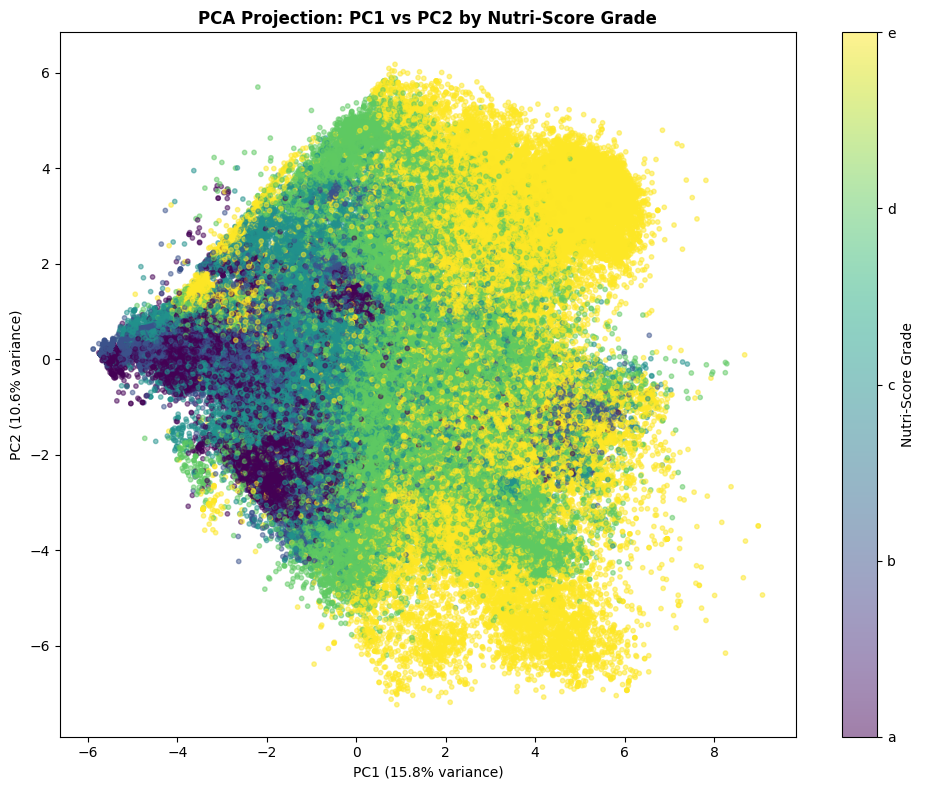

In [31]:
if 'PC1' in df_pca.columns and 'PC2' in df_pca.columns and 'nutriscore_grade' in df_pca.columns:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    grade_order = sorted(df_pca['nutriscore_grade'].unique())
    
    scatter = ax.scatter(
        df_pca['PC1'],
        df_pca['PC2'],
        c=pd.Categorical(df_pca['nutriscore_grade'], categories=grade_order).codes,
        cmap='viridis',
        alpha=0.5,
        s=10
    )
    
    cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(grade_order)))
    cbar.ax.set_yticklabels(grade_order)
    cbar.set_label('Nutri-Score Grade')
    
    ax.set_xlabel("PC1 (" + str(round(explained_var[0]*100, 1)) + "% variance)")
    ax.set_ylabel("PC2 (" + str(round(explained_var[1]*100, 1)) + "% variance)")
    ax.set_title('PCA Projection: PC1 vs PC2 by Nutri-Score Grade', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

---
# Final Preprocessed Dataset Summary

This section provides a comprehensive overview of the final preprocessed dataset ready for model training.

In [32]:
print("Initial dataset:", df_raw.shape[0], "rows x", df_raw.shape[1], "columns")
print("Final dataset:  ", df_pca.shape[0], "rows x", df_pca.shape[1], "columns")

rows_removed = df_raw.shape[0] - df_pca.shape[0]
percentage_removed = round((rows_removed / df_raw.shape[0]) * 100, 2)

print("Rows removed:   ", rows_removed, "(", percentage_removed, "%)")

print("Pipeline stages:")
print("  1. Outlier Removal:", outlier_handler.rows_removed_, "rows removed")
print("  2. Feature Encoding:", len(categorical_features), "features encoded")
print("  3. Feature Engineering:", len(engineered_features), "new features")
print("  4. Feature Scaling:", len(scaler.scalers_), "features scaled")
print("  5. PCA:", len(pca_features), "features ->", pca_reducer.n_components_selected_, "components")

Initial dataset: 250000 rows x 22 columns
Final dataset:   193648 rows x 36 columns
Rows removed:    56352 ( 22.54 %)
Pipeline stages:
  1. Outlier Removal: 56352 rows removed
  2. Feature Encoding: 3 features encoded
  3. Feature Engineering: 10 new features
  4. Feature Scaling: 48 features scaled
  5. PCA: 48 features -> 32 components


### Final Dataset Structure

The final dataset has the following structure:

In [33]:
display(df_pca.info())

<class 'pandas.core.frame.DataFrame'>
Index: 193648 entries, 0 to 249999
Data columns (total 36 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   PC1               193648 non-null  float64
 1   PC2               193648 non-null  float64
 2   PC3               193648 non-null  float64
 3   PC4               193648 non-null  float64
 4   PC5               193648 non-null  float64
 5   PC6               193648 non-null  float64
 6   PC7               193648 non-null  float64
 7   PC8               193648 non-null  float64
 8   PC9               193648 non-null  float64
 9   PC10              193648 non-null  float64
 10  PC11              193648 non-null  float64
 11  PC12              193648 non-null  float64
 12  PC13              193648 non-null  float64
 13  PC14              193648 non-null  float64
 14  PC15              193648 non-null  float64
 15  PC16              193648 non-null  float64
 16  PC17              193648 

None

---
# Conclusion

The preprocessing pipeline successfully transforms raw nutritional data into a clean, normalized, and reduced-dimensionality feature set suitable for machine learning models.

### Key Transformations Applied:

1. **Data Quality**: Removed features with excessive missing values (>95%) and imputed remaining missing values using robust strategies

2. **Outlier Management**: Applied domain-based validation to ensure nutritional values fall within physically plausible ranges

3. **Categorical Encoding**: Converted categorical variables using appropriate strategies (Multi-Label, One-Hot, Target Encoding) based on feature characteristics

4. **Feature Engineering**: Created domain-informed derived features capturing nutritional relationships and thresholds

5. **Feature Scaling**: Standardized numerical features using adaptive scaling methods based on distribution characteristics

6. **Dimensionality Reduction**: Applied PCA to reduce feature space while preserving 95% of variance, creating uncorrelated principal components

The final dataset is now ready for model training and evaluation.